In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

# Loading and Sampling

In [2]:
df = pd.read_csv('preprocessed_data/2019_yellow_processed.csv')
df = df.sample(n=1000000).reset_index(drop=True)

# Divide class by eqaul-width

In [3]:
df['tip_amount'].describe()

count    1000000.000000
mean           3.019148
std            2.354872
min            0.010000
25%            1.700000
50%            2.350000
75%            3.380000
max           42.540000
Name: tip_amount, dtype: float64

In [4]:
df.loc[df['tip_amount']<2,'tip_class']=int(0)
df.loc[(df['tip_amount']>=2) & (df['tip_amount']<4),'tip_class']=int(1)
df.loc[(df['tip_amount']>=4),'tip_class']=int(2)

# Make training dataset 

In [5]:
outcome_df = df['tip_class']

In [6]:
train_df = df[['date_type', 'TAVG', 'SNOW', 'SNWD', 'time_of_day', 'fare_amount', 'trip_distance', 'total_amount']]

# Preprocessing 

In [7]:
train_df = pd.concat([train_df, 
                      pd.get_dummies(train_df['date_type'], prefix='date_type'), 
                      pd.get_dummies(train_df['time_of_day'], prefix='t_of_d')], axis=1) 
train_df.drop(columns=['date_type', 'time_of_day'], inplace=True)

In [8]:
for colname in ['TAVG', 'SNOW', 'SNWD', 'fare_amount', 'trip_distance', 'total_amount']:
    train_df[colname] = StandardScaler().fit_transform(train_df[[colname]]).flatten()

# Modelling

In [9]:
x_train, x_dev, y_train, y_dev = train_test_split(train_df, outcome_df, test_size=0.25)

In [10]:
model = LogisticRegression(max_iter=10000, multi_class='multinomial', solver='newton-cg').fit(x_train, y_train)
model.score(x_train, y_train), model.score(x_dev, y_dev)

(0.8329146666666667, 0.833676)

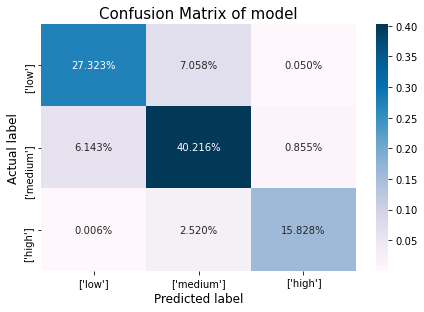

In [11]:
y_dev_pred = model.predict(x_dev)
cnf_matrix = confusion_matrix(y_dev, y_dev_pred)
class_names = list(np.unique(y_dev))
class_names[0] = ['low']
class_names[1] = ['medium']
class_names[2] = ['high']

sns.heatmap(cnf_matrix/np.sum(cnf_matrix), xticklabels=class_names, yticklabels=class_names, annot=True,
            fmt='.3%', cmap='PuBu')
plt.tight_layout()
plt.title('Confusion Matrix of model', fontsize=15)
plt.ylabel('Actual label',fontsize=12)
plt.xlabel('Predicted label',fontsize=12)
plt.savefig('Confusion Matrix of model.png')

In [12]:
print('Accuracy:{:.3f}'.format(accuracy_score(y_dev, y_dev_pred)))

Accuracy:0.834


In [13]:
# create classification report
class_report = classification_report(y_dev, y_dev_pred)
print(class_report)

              precision    recall  f1-score   support

         0.0       0.82      0.79      0.80     86077
         1.0       0.81      0.85      0.83    118035
         2.0       0.95      0.86      0.90     45888

    accuracy                           0.83    250000
   macro avg       0.86      0.84      0.85    250000
weighted avg       0.84      0.83      0.83    250000



# Prediction

In [14]:
df_predict = pd.read_csv('preprocessed_data/2020_yellow_processed.csv')

In [15]:
# Preprocessing test dataset
test_df = df_predict[['date_type', 'TAVG', 'SNOW', 'SNWD', 'time_of_day', 'fare_amount', 'trip_distance', 'total_amount']]
test_df = pd.concat([test_df, 
                      pd.get_dummies(test_df['date_type'], prefix='date_type'), 
                      pd.get_dummies(test_df['time_of_day'], prefix='t_of_d')], axis=1) 
test_df.drop(columns=['date_type', 'time_of_day'], inplace=True)
for colname in ['TAVG', 'SNOW', 'SNWD', 'fare_amount', 'trip_distance', 'total_amount']:
    test_df[colname] = StandardScaler().fit_transform(test_df[[colname]]).flatten()

In [16]:
pred = model.predict(test_df)

In [17]:
# divide class by eqaul-width for test set 
df_predict.loc[df_predict['tip_amount']<2,'tip_class']=int(0)
df_predict.loc[(df_predict['tip_amount']>=2) & (df_predict['tip_amount']<4),'tip_class']=int(1)
df_predict.loc[(df_predict['tip_amount']>=4),'tip_class']=int(2)

In [18]:
# extract the column of actual class
pred_actual = df_predict['tip_class']

In [19]:
print('Accuracy:{:.3f}'.format(accuracy_score(pred_actual,pred)))

Accuracy:0.774


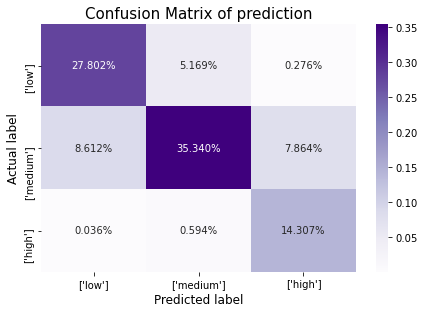

In [20]:
cnf_matrix = confusion_matrix(pred_actual,pred)
class_names = list(np.unique(pred_actual))

class_names[0] = ['low']
class_names[1] = ['medium']
class_names[2] = ['high']
sns.heatmap(cnf_matrix/np.sum(cnf_matrix), xticklabels=class_names, yticklabels=class_names, annot=True,
            fmt='.3%', cmap='Purples')
plt.tight_layout()
plt.title('Confusion Matrix of prediction',fontsize=15)
plt.ylabel('Actual label',fontsize=12)
plt.xlabel('Predicted label',fontsize=12)
plt.savefig('Confusion Matrix of prediction.png')

In [21]:
class_report_prediction=classification_report(pred_actual,pred)
print(class_report_prediction)

              precision    recall  f1-score   support

         0.0       0.76      0.84      0.80    179384
         1.0       0.86      0.68      0.76    279576
         2.0       0.64      0.96      0.77     80595

    accuracy                           0.77    539555
   macro avg       0.75      0.83      0.77    539555
weighted avg       0.79      0.77      0.77    539555

